# Part 2: Implementing a simple Convolutional classifier

**Question 7**: Use the dataloaders to load both the train and the test set into large tensors:
one for the instances, one for the labels. Split the training data into 50 000 training instances
and 10 000 validation instances. Then write a training loop that loops over batches of 16
instances at a time.

Notes:

● Note that the range() function in python can be called with three arguments, to iterate
in large steps.

● It's useful to know that the slice syntax is forgiving if the second argument is out of
bounds. If you have an array with 32 elements then arr[30:36], will just give you
the last two elements without complaining.

● If you have a GPU, make sure not to load these data tensors into GPU memory. It's
better to load each batch into the GPU memory as you loop over the data

We'll use the following network:


| Input size | Layer / Operation | 
:----------:|:-----------------:|
| (batch, 1, 28, 28) | nn.Conv2d | 
| | kernel size 3x3, stride 1, padding 1, 16 output channels | 
| (batch, 16, 28, 28) | ReLU | 
| (batch, 16, 28, 28) | 2x2 Max pool | 
| (batch, 16, 14, 14) | nn.Conv2D | 
| | kernel size 3x3, stride 1, padding 1, 32 output channels |
| (batch, 32, 14, 14) | ReLU | 
| (batch, 32, 14, 14) | 2x2 Max pool |
| (batch, 32, 7, 7) | nn.Conv2D |
| | kernel size 3x3, stride 1, padding 1, 64 output channels |
| (batch, 64, 7, 7) | ReLU |
| (batch, 64, 7, 7) | 2x2 Max pool |
| (batch, 64, 3, 3) | Reshape to flatten the image |
| (batch, 64 * 3 * 3) | Linear layer | 
| (batch, 10) | |


Use cross-entropy as the loss function, and Adam as the optimizer. Most of this was covered
in the PyTorch 60 minute blitz.

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision import transforms




BATCH_SIZE = 64
EPOCHS = 10

train = datasets.MNIST('MNIST_data/',
                       download=True,
                       train=True,
                       transform=ToTensor())
# trainloader = torch.utils.data.DataLoader(train, 
#                                           batch_size=BATCH_SIZE, 
#                                           shuffle=True,
#                                           num_workers=2)

test = datasets.MNIST('MNIST_data/',
                    download=True,
                    train=False,
                    transform=ToTensor())

# testloader = torch.utils.data.DataLoader(test,
#                                         batch_size=BATCH_SIZE,
#                                         shuffle=True,
#                                         num_workers=2)

# CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:

def q7(train_data: torch.utils.data.Dataset, test_data: torch.utils.data.Dataset):
    
    

    # Split the training data into training and validation sets
    train_data, val_data = random_split(train_data, [50000, 10000])

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, num_workers=2)
    return train_loader, val_loader, test_loader



def training_loop(n_epochs: int,
                 optimizer: torch.optim.Optimizer,
                 model: torch.nn.Module,
                 loss_function: torch.nn.Module,
                 train_loader: torch.utils.data.DataLoader,
                 val_loader: torch.utils.data.DataLoader,
                 device: torch.device):
    print(f'{str("*"*10)}STARTING TRAINING{str("*"*10)}')
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    model = model.to(device)
    loss_function = loss_function.to(device)
    
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}/{n_epochs} \n {'-'*30}")
        
        running_acc = 0.0
        running_loss = 0.0
        total_samples = 0
        model.train()
        for batch, (images, labels) in enumerate(train_loader):
            # images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = loss_function(output, labels)
            running_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accuracy training
            running_acc += (output.argmax(1) == labels).sum().item()
            total_samples += labels.shape[0]

            if batch % 500 == 0:
                loss, current = loss.item(), batch * len(images)
                print(f"Loss: {loss:>7f}  [{current:>5d}/{len(train_loader.dataset):>5d}]")


        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_acc / total_samples
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc*100:.2f}%")

        running_acc = 0.0
        running_loss = 0.0
        total_samples = 0
        print(f"{'*'*10} Evaluation {'*'*10}")
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                # images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = loss_function(output, labels)

                running_loss += loss.item()
                running_acc += (output.argmax(1) == labels).sum().item()
                total_samples += labels.shape[0]

            epoch_loss = running_loss / len(val_loader)
            epoch_acc = running_acc / total_samples
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)
            print(f" AVG Val Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_acc*100:.2f}%")
            print()

    print("Finished Training")

    return (train_loss, val_loss, train_acc, val_acc)



**Question 8**: Build this network and tune the hyperparameters until you get a good baseline
performance you are happy with. You should be able to get at least 95% accuracy. If training
takes too long, you can reduce the number of channels in each layer.
In the lectures, we briefly discussed the idea of data augmentation. This is easily added to
our network.

In [3]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_layer = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = self.linear_layer(x)
        return x

In [4]:
model = ConvNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
print(model)


data = q7(train, test)

(train_loader,
val_loader,
test_loader) = data

ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)


In [5]:
results = training_loop(EPOCHS, optimizer, model, criterion, train_loader, val_loader, device)

**********STARTING TRAINING**********
Epoch 1/10 
 ------------------------------
Loss: 2.304071  [    0/50000]
Loss: 0.036520  [ 8000/50000]
Loss: 0.944533  [16000/50000]
Loss: 0.006256  [24000/50000]
Loss: 0.384491  [32000/50000]
Loss: 0.040151  [40000/50000]
Loss: 0.014779  [48000/50000]
Training Loss: 0.1617, Training Accuracy: 94.89%
********** Evaluation **********
 AVG Val Loss: 0.0728, Validation Accuracy: 97.59%

Epoch 2/10 
 ------------------------------
Loss: 0.003522  [    0/50000]
Loss: 0.022840  [ 8000/50000]
Loss: 0.006726  [16000/50000]
Loss: 0.027698  [24000/50000]
Loss: 0.000375  [32000/50000]
Loss: 0.055170  [40000/50000]
Loss: 0.001485  [48000/50000]
Training Loss: 0.0525, Training Accuracy: 98.31%
********** Evaluation **********
 AVG Val Loss: 0.0418, Validation Accuracy: 98.71%

Epoch 3/10 
 ------------------------------
Loss: 0.003105  [    0/50000]
Loss: 0.062803  [ 8000/50000]
Loss: 0.026960  [16000/50000]
Loss: 0.006600  [24000/50000]
Loss: 0.108308  [32000

In [6]:
def test(model: nn.Module,
        loss_function: nn.Module,
        test_loader: torch.utils.data.DataLoader,
        device: torch.device):
        
    running_acc = 0.0
    running_loss = 0.0
    total_samples = 0
    print(f"{'*'*10} Testing {'*'*10}")
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            # images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = loss_function(output, labels)

            running_loss += loss.item()
            running_acc += (output.argmax(1) == labels).sum().item()
            total_samples += labels.shape[0]

        loss_ = running_loss / len(test_loader)
        acc = running_acc / total_samples

        print(f" AVG Test Loss: {loss_:.4f}, Test Accuracy: {acc*100:.2f}%")


In [7]:
test(model, criterion, test_loader, device)

********** Testing **********
 AVG Test Loss: 0.0353, Test Accuracy: 99.07%


In [8]:
import matplotlib.pyplot as plt
import numpy as np
# FIRST TRY

def plot_results(results: tuple, save_fig_name: str) -> None:
    
    # results = [item.to('cpu') for item in results]
    (train_loss, val_loss, train_acc, val_acc) = results

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    epochs = np.arange(1, EPOCHS+1)

    axs[0].plot(train_loss, label='Training Loss')
    axs[0].plot(val_loss, label='Validation Loss')
    axs[0].set_xticks(epochs)
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(train_acc, label='Training Accuracy')
    axs[1].plot(val_acc, label='Validation Accuracy')
    axs[1].set_xticks(epochs)
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    plt.savefig(save_fig_name+'.pdf')
    plt.show()

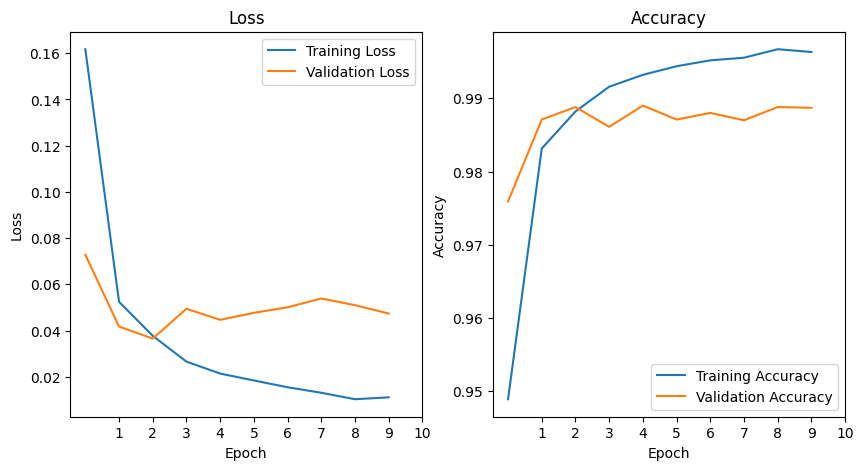

In [9]:
plot_results(results, 'first_try')

In [11]:
# Trying SGD with momentum

model_new = ConvNN()
model_new.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_new.parameters(), lr=0.001, momentum=0.9)
print(model_new)

results_new = training_loop(EPOCHS, optimizer, model_new, criterion, train_loader, val_loader, device)
plot_results(results_new, 'SGD_no_augmented')

test(model_new, criterion, testloader, device)



ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)


NameError: name 'trainloader' is not defined

**Question 9**: Add some data augmentations when creating the dataset for the training set.
Why do we only augment the training data? Play around with the augmentations available in
torchvision. Try to get better performance than the baseline. Once you are happy with your
choice of augmentations, run both the baseline and the augmented version on the test set
and report the accuracies in your report.

Notes:

● When we use data augmentation, using the data loaders to load the whole data into
big tensors (as we did in Question 7) creates a problem, because this means that the
transformations are only applied once per instance in the training set. Instead, we
would like to iterate multiple times over the dataset, and each time get different
transformations. You can achieve this by using the data loaders to iterate through the
data (as opposed to using the big tensors from Question 7). Make sure to create a
validation set first by applying the random_split function to the training set:

https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

○ Apply this to the dataset object before passing it to the dataloader.

In [ ]:
from torchvision import datasets, transforms
import torch

def data_augmented(BATCH_SIZE: int = 16) -> tuple:

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ])

    train = datasets.MNIST('MNIST_data/',
                           download=True,
                           train=True,
                           transform=transform)

    test = datasets.MNIST('MNIST_data/',
                          download=True,
                          train=False,
                          transform=transforms.ToTensor())


    train_dataset, val_dataset = random_split(train, [50000, 10000])

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    return trainloader, valloader, testloader


In [ ]:
trainloader, valloader, testloader = data_augmented(16)

In [ ]:
model_new2 = ConvNN()
model_new2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new.parameters(), lr=0.001, betas=(0.9, 0.999))
print(model_new2)

results_new2 = training_loop(EPOCHS, optimizer, model_new2, criterion, trainloader, valloader, device)

ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)
**********STARTING TRAINING**********
Epoch 1/10 
 ------------------------------
Loss: 2.327021  [    0/50000]
Loss: 0.418143  [ 8000/50000]
Loss: 0.322383  [16000/50000]
Loss: 0.232691  [24000/50000]
Loss: 0.091721  [32000/50000]
Loss: 0.221634  [40000/50000]
Loss: 0.087515  [48000/50000]
Training Loss: 0.3080, Training Accuracy: 89.86%
********** Evaluation **********
 AVG Val Loss: 0.1312, Validation Accuracy: 95.97%

Epoch 2/10 
 ------------------------------
Loss: 0.075738  [    0/50000]
Loss: 0.117996  [ 8000/50000]
Loss: 0.151701  [16000/50000]
Loss: 0.003621  [24000/50000]
Loss: 0.021043 

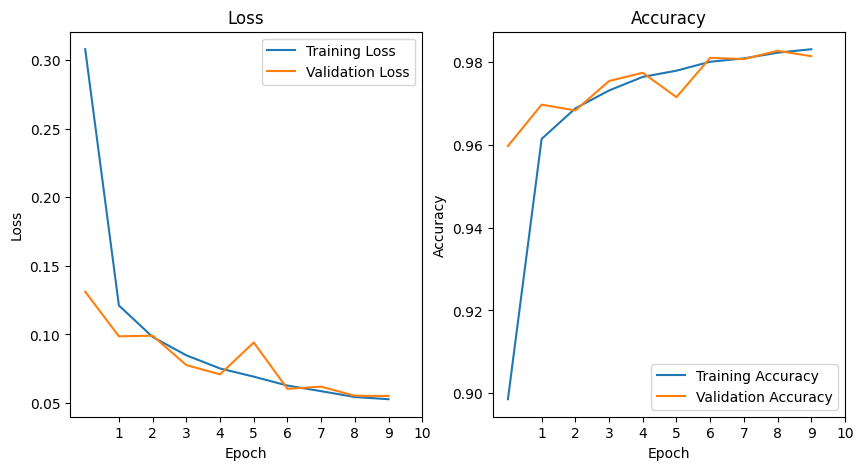

In [ ]:
plot_results(results_new2, 'second_try')

In [ ]:
test(model_new, criterion, testloader, device)

********** Testing **********
 AVG Test Loss: 0.0500, Test Accuracy: 98.51%


ConvNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer): Linear(in_features=576, out_features=10, bias=True)
)
**********STARTING TRAINING**********
Epoch 1/10 
 ------------------------------
Loss: 2.317711  [    0/50000]
Loss: 2.123851  [ 8000/50000]
Loss: 0.588835  [16000/50000]
Loss: 0.568357  [24000/50000]
Loss: 0.574446  [32000/50000]
Loss: 0.116488  [40000/50000]
Loss: 0.124665  [48000/50000]
Training Loss: 0.8620, Training Accuracy: 71.35%
********** Evaluation **********
 AVG Val Loss: 0.3072, Validation Accuracy: 89.98%

Epoch 2/10 
 ------------------------------
Loss: 0.088009  [    0/50000]
Loss: 0.091520  [ 8000/50000]
Loss: 0.262634  [16000/50000]
Loss: 0.717571  [24000/50000]
Loss: 0.232266 

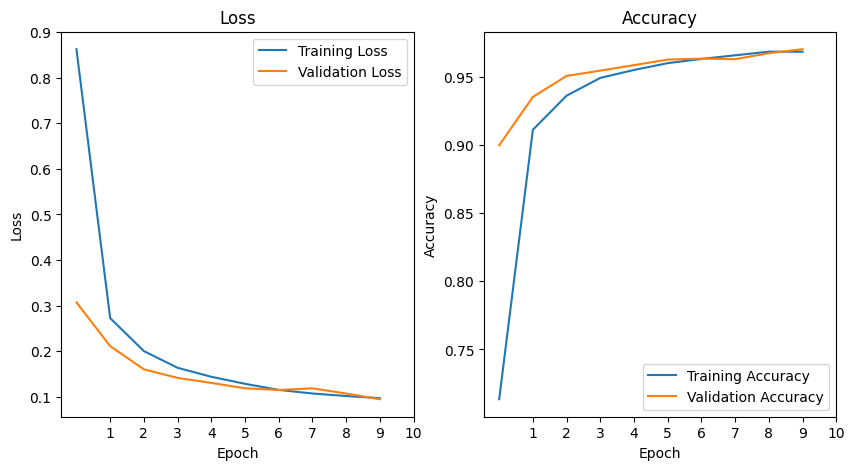

********** Testing **********
 AVG Test Loss: 0.0721, Test Accuracy: 97.64%


In [ ]:
# Trying SGD with momentum

model_new3 = ConvNN()
model_new3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_new3.parameters(), lr=0.001, momentum=0.9)
print(model_new3)

results_new3 = training_loop(EPOCHS, optimizer, model_new3, criterion, trainloader, valloader, device)
plot_results(results_new3, 'SGg_augmented')

test(model_new3, criterion, testloader, device)

